In [53]:
# import libraries
import glob
import pandas as pd
import seaborn as sn
import datetime
import matplotlib.pylab as plt
import itertools
import matplotlib.ticker as ticker
import numpy as np

In [54]:
# get the absolute path of all Excel files 
all_excel_files = glob.glob("data/Device*.xlsx")

# read all Excel files at once
original_devices_df = pd.concat(pd.read_excel(excel_file) for excel_file in all_excel_files)
original_devices_df = original_devices_df.drop_duplicates()
original_devices_df.describe()


/home/amarton/.local/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Organization,License plate No.,Vehicle color,Device model,Encryption chip ID,Positioning module,Host & peripheral version No.,Host & peripheral version No..1,Host & peripheral version No..2,Host & peripheral version No..3,...,Storage module4.5,Storage module4.6,Peripheral status1,Peripheral status1.1,Peripheral status1.2,Peripheral status2,Peripheral status2.1,Peripheral status2.2,Update time,Offline time
count,25610,32770,32770,22347,32770,22131,2,21705,21272,21266,...,404,1,1730,1730,1730,1730,1730,1730,22347,12651
unique,265,32765,2,14,32770,3,2,85,12,8,...,4,1,3,3,1728,3,3,1728,12179,11349
top,LATAM M1N,007100743D,Others,X1N_AI-M1N_TKH,Encryption chip ID,GPS,Hardware,X1N_AI_V3.5.6.8_T230918.70,GTP:20190821,EC25AFFAR07A08M4G,...,7,Energized duration (H),OBD data analysis status,Parsing failed,2024-04-03 13:53:47,OBD authorization status,Authorized,2024-04-03 13:53:47,2024-04-03 16:15:03,2023-08-21 02:36:34
freq,6867,2,32769,17008,1,22120,1,8893,9775,9444,...,390,1,1726,1726,2,1726,1726,2,79,29


In [55]:
# fleets_of_interest = ["Quickway Dist - 1508","H R Ewell - 4094","Saddle Creek Corp - 2303","Shaw Regional - 1333","Shaw IPT - 1331","Shaw OTR - 2108","Boise Cascade - 4241","CRC Transport - 8114" ]
fleets_of_interest = ["H R Ewell - 4094","Saddle Creek Corp - 2303"]

In [56]:
devices_df = original_devices_df.copy()
devices_df = devices_df[devices_df["Device model"] == "X1N_AI-M1N_TKH"]
devices_df = devices_df[(devices_df["Organization"].isin(fleets_of_interest))]

devices_df.describe()

,Organization,License plate No.,Vehicle color,Device model,Encryption chip ID,Positioning module,Host & peripheral version No.,Host & peripheral version No..1,Host & peripheral version No..2,Host & peripheral version No..3,...,Storage module4.5,Storage module4.6,Peripheral status1,Peripheral status1.1,Peripheral status1.2,Peripheral status2,Peripheral status2.1,Peripheral status2.2,Update time,Offline time
count,704,704,704,704,704,704,0,704,698,702,...,0,0,0,0,0,0,0,0,704,325
unique,2,704,1,1,704,1,0,8,2,1,...,0,0,0,0,0,0,0,0,421,325
top,Saddle Creek Corp - 2303,007100A851,Others,X1N_AI-M1N_TKH,007100A851,GPS,NaN,X1N_AI_V3.5.6.8_T230918.70,GTP:20190821,EC25AFFAR07A08M4G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-04-03 16:15:03,2024-01-09 15:13:50
freq,451,1,704,704,1,704,NaN,670,695,702,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,1


In [57]:

# get the absolute path of all Excel files 
all_excel_files = glob.glob("data/Alarm*.xlsx")

# read all Excel files at once
original_alarms_df = pd.concat(pd.read_excel(excel_file) for excel_file in all_excel_files)
original_alarms_df = original_alarms_df.drop_duplicates()


/home/amarton/.local/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/home/amarton/.local/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/home/amarton/.local/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/home/amarton/.local/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/home/amarton/.local/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:

In [58]:
#Drop columns with NaN
alarms_df = original_alarms_df.copy()
alarms_df = alarms_df.drop_duplicates()
display(alarms_df)
alarms_df = alarms_df[alarms_df["Type"] == "Video Loss Alarm"]
alarms_df = alarms_df.drop(columns=["Alarm evidence", "Alarm level", "Category", "Alarm status", "Driver", "Driver employee ID", "Label"])
alarms_df = alarms_df.sort_values('Alarm time')
alarms_df["Alarm time"] = pd.to_datetime(alarms_df["Alarm time"],yearfirst=True)

alarms_df = alarms_df[alarms_df["Alarm time"]>=datetime.datetime(year=2024, month=1, day=1)]


,Type,License plate number,Driver,Driver employee ID,Fleet,Device number,Speed,Alarm status,Category,Alarm level,Label,Alarm time,Alarm evidence,Day
0,Video Loss Alarm,0071008892,NaN,NaN,NaN,0071008892,28mph,To be processed,Camera Issue,Other Risk,NaN,01-27-2024 23:59:55,http://ft-api.prod.trimblevi.com:20111/mobile/...,NaN
1,Video Loss Alarm,0071007612,NaN,NaN,LATAM M1N,0071007612,0mph,To be processed,Camera Issue,Other Risk,NaN,01-27-2024 23:59:55,http://ft-api.prod.trimblevi.com:20111/mobile/...,NaN
2,Video Loss Alarm,007100736F,NaN,NaN,LATAM M1N,007100736F,0mph,To be processed,Camera Issue,Other Risk,NaN,01-27-2024 23:59:54,http://ft-api.prod.trimblevi.com:20111/mobile/...,NaN
3,Video Loss Alarm,0071004D55,NaN,NaN,Shaw IPT - 1331,0071004D55,37mph,To be processed,Camera Issue,Other Risk,NaN,01-27-2024 23:59:37,http://ft-api.prod.trimblevi.com:20111/mobile/...,NaN
4,Video Loss Alarm,007100779A,NaN,NaN,LATAM M1N,007100779A,0mph,To be processed,Camera Issue,Other Risk,NaN,01-27-2024 23:59:29,http://ft-api.prod.trimblevi.com:20111/mobile/...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144805,Video Loss Alarm,007100745E,NaN,NaN,LATAM M1N,007100745E,4mph,To be processed,Camera Issue,Other Risk,NaN,12-31-2023 00:00:21,http://ft-api.prod.trimblevi.com:20111/mobile/...,NaN
144806,Video Loss Alarm,00D20033C1,NaN,NaN,LATAM C6,00D20033C1,0mph,To be processed,Camera Issue,Other Risk,NaN,12-31-2023 00:00:06,http://ft-api.prod.trimblevi.com:20111/mobile/...,NaN
144807,Video Loss Alarm,00D20034FC,NaN,NaN,Production Customers,00D20034FC,11mph,To be processed,Camera Issue,Other Risk,NaN,12-31-2023 00:00:04,http://ft-api.prod.trimblevi.com:20111/mobile/...,NaN
144808,Video Loss Alarm,0071000481,NaN,NaN,LATAM M1N,0071000481,39mph,To be processed,Camera Issue,Other Risk,NaN,12-31-2023 00:00:02,http://ft-api.prod.trimblevi.com:20111/mobile/...,NaN


,label,lower_whisker,lower_quartile,median,upper_quartile,upper_whisker
0,count,1.0,14.0,114.0,457.0,1114.0


,License plate number,count
0,0071000010,3
1,0071000014,11
2,0071000081,3
3,0071000407,152
4,0071000408,994
...,...,...
7443,00D2003D0F,29
7444,00D2003D3D,76
7445,00D2003D3E,14
7446,00D20189B7,7


,License plate number,count
8,0071000418,2169
9,0071000419,1764
25,0071000442,2371
39,0071000461,1593
45,007100048A,1603
...,...,...
6501,00D20034E3,1146
6696,00D20036E6,1600
6805,00D20037B8,1929
6860,00D20038A8,1225


,Type,License plate number,Fleet,Device number,Speed,Alarm time,Day
138574,Video Loss Alarm,0071007947,LATAM M1N,0071007947,0mph,2024-01-01 00:00:01,NaN
138573,Video Loss Alarm,0071007B92,LATAM M1N,0071007B92,0mph,2024-01-01 00:00:05,NaN
138572,Video Loss Alarm,0071013D04,LATAM M1N,0071013D04,5mph,2024-01-01 00:00:34,NaN
138571,Video Loss Alarm,0071007335,LATAM M1N,0071007335,6mph,2024-01-01 00:01:22,NaN
138570,Video Loss Alarm,0071007479,LATAM M1N,0071007479,2mph,2024-01-01 00:02:02,NaN
...,...,...,...,...,...,...,...
4,Video Loss Alarm,007101395C,LATAM M1N,007101395C,0mph,2024-03-31 23:59:51,NaN
3,Video Loss Alarm,0071013949,LATAM M1N,0071013949,0mph,2024-03-31 23:59:52,NaN
2,Video Loss Alarm,00D20030AC,Production Customers,00D20030AC,0mph,2024-03-31 23:59:53,NaN
1,Video Loss Alarm,00D200302A,LATAM C6,00D200302A,15mph,2024-03-31 23:59:53,NaN


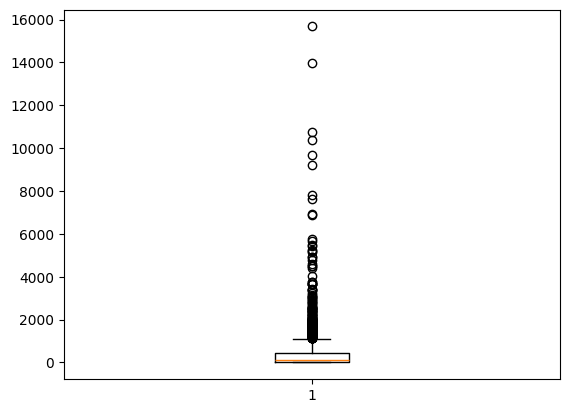

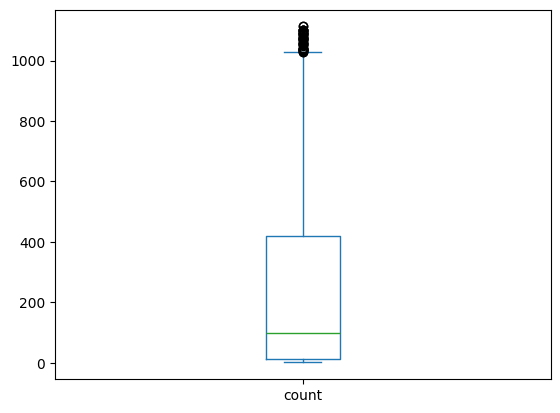

In [59]:
#REMOVE OUTLIER DEVICES
def get_box_plot_data(labels, bp):
    rows_list = []

    for i in range(len(labels)):
        dict1 = {}
        dict1['label'] = labels[i]
        dict1['lower_whisker'] = bp['whiskers'][i*2].get_ydata()[1]
        dict1['lower_quartile'] = bp['boxes'][i].get_ydata()[1]
        dict1['median'] = bp['medians'][i].get_ydata()[1]
        dict1['upper_quartile'] = bp['boxes'][i].get_ydata()[2]
        dict1['upper_whisker'] = bp['whiskers'][(i*2)+1].get_ydata()[1]
        rows_list.append(dict1)

    return pd.DataFrame(rows_list)

camera_failure_freq = alarms_df.groupby(["License plate number"])["License plate number"].value_counts()
camera_failure_freq = camera_failure_freq.to_frame().reset_index()
bp = plt.boxplot(camera_failure_freq['count'])
bp_info = get_box_plot_data(['count'],bp)
display(bp_info)
display(camera_failure_freq)
# #Show outlier devices for separate analysis
outlier_devices = camera_failure_freq[camera_failure_freq['count']>bp_info['upper_whisker'][0]]
display(outlier_devices)

filtered_devices = camera_failure_freq[camera_failure_freq['count']<bp_info['upper_whisker'][0]]

filtered_devices.plot.box()
# Remove outliers
alarms_df = alarms_df[~ alarms_df["License plate number"].isin(outlier_devices["License plate number"])]
devices_df = devices_df[~ devices_df["License plate No."].isin(outlier_devices["License plate number"])]
alarms_df.describe()
alarms_df

In [60]:
#NUMBER OF FAILURES PER DEVICE AND DATE

num_failures = alarms_df.copy()
num_failures["Alarm time"] = pd.to_datetime(num_failures["Alarm time"],yearfirst=True)

date_grouper = num_failures["Alarm time"].dt.date

num_failures = num_failures.groupby(['License plate number', date_grouper])["Type"].value_counts()
num_failures = num_failures.to_frame().reset_index().rename(columns={"count":"Failures", "Alarm time":"Date"})
num_failures_by_device_date = num_failures.pivot(index="License plate number", columns="Date", values="Failures").reset_index()

display(num_failures_by_device_date)



Date,License plate number,2024-01-01,2024-01-02,2024-01-03,2024-01-04,2024-01-05,2024-01-06,2024-01-14,2024-01-15,2024-01-16,...,2024-03-15,2024-03-16,2024-03-17,2024-03-18,2024-03-19,2024-03-20,2024-03-21,2024-03-22,2024-03-23,2024-03-31
0,0071000010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0071000014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0071000081,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0071000407,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,4.0,...,2.0,1.0,2.0,1.0,1.0,1.0,2.0,1.0,NaN,3.0
4,0071000408,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,18.0,17.0,8.0,18.0,15.0,13.0,7.0,14.0,10.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7192,00D2003D0F,NaN,1.0,NaN,1.0,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,NaN
7193,00D2003D3D,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7194,00D2003D3E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0
7195,00D20189B7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,4.0,NaN,NaN


In [61]:
#FILTERING BY UPDATE TIME OF DEVICES

#Filtering to get only active devices during the period
active_devices_df = devices_df.copy()
active_devices_df = active_devices_df.rename(columns={"Update time ":"Active time"})
active_devices_df["Active time"] = pd.to_datetime(active_devices_df["Active time"],yearfirst=True)
active_devices_df = active_devices_df[(active_devices_df["Active time"]>(alarms_df["Alarm time"].min()))]
alarms_df = alarms_df[(alarms_df["License plate number"].isin(active_devices_df["License plate No."]))]

display(active_devices_df)

,Organization,License plate No.,Vehicle color,Device model,Encryption chip ID,Positioning module,Host & peripheral version No.,Host & peripheral version No..1,Host & peripheral version No..2,Host & peripheral version No..3,...,Storage module4.5,Storage module4.6,Peripheral status1,Peripheral status1.1,Peripheral status1.2,Peripheral status2,Peripheral status2.1,Peripheral status2.2,Active time,Offline time
7532,Saddle Creek Corp - 2303,007100A851,Others,X1N_AI-M1N_TKH,007100A851,GPS,NaN,V3.3.22.3_R21110504,GTP:20190821,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-01-09 15:11:54,2024-01-09 15:13:50
7540,H R Ewell - 4094,00710092D6,Others,X1N_AI-M1N_TKH,00710092D6,GPS,NaN,X1N_AI_V3.5.6.8_T230918.70,GTP:20190821,EC25AFFAR07A08M4G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-04-03 10:11:04,2024-04-03 10:12:55
9126,H R Ewell - 4094,007100951D,Others,X1N_AI-M1N_TKH,007100951D,GPS,NaN,X1N_AI_V3.5.6.8_T230918.70,NaN,EC25AFFAR07A08M4G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-04-03 14:24:38,2024-04-03 14:24:40
10449,H R Ewell - 4094,0071004570,Others,X1N_AI-M1N_TKH,0071004570,GPS,NaN,X1N_AI_V3.5.6.8_T230918.70,GTP:20190821,EC25AFFAR07A08M4G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-04-03 04:58:04,2024-04-03 04:59:33
10450,H R Ewell - 4094,007100451D,Others,X1N_AI-M1N_TKH,007100451D,GPS,NaN,X1N_AI_V3.5.6.8_T230918.70,GTP:20190821,EC25AFFAR07A08M4G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-04-03 16:14:19,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25654,H R Ewell - 4094,007100993C,Others,X1N_AI-M1N_TKH,007100993C,GPS,NaN,X1N_AI_V3.5.6.8_T230918.70,GTP:20190821,EC25AFFAR07A08M4G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-04-03 16:15:51,NaN
25773,H R Ewell - 4094,0071009841,Others,X1N_AI-M1N_TKH,0071009841,GPS,NaN,X1N_AI_V3.5.6.8_T230918.70,GTP:20190821,EC25AFFAR07A08M4G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-03-28 15:04:16,2024-03-28 15:05:58
25873,H R Ewell - 4094,00710097DF,Others,X1N_AI-M1N_TKH,00710097DF,GPS,NaN,X1N_AI_V3.5.6.8_T230918.70,GTP:20190821,EC25AFFAR07A08M4G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-04-03 16:15:54,NaN
26089,H R Ewell - 4094,00710096BE,Others,X1N_AI-M1N_TKH,00710096BE,GPS,NaN,X1N_AI_V3.5.6.8_T230918.70,GTP:20190821,EC25AFFAR07A08M4G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-04-03 13:19:18,2024-04-03 13:20:48


In [62]:
num_failed_devices_by_fleet = alarms_df.copy()

num_failed_devices_by_fleet = num_failed_devices_by_fleet.groupby(['Fleet'])["License plate number"].nunique()
num_available_devices_by_fleet = active_devices_df.groupby(['Organization'])["License plate No."].nunique()
result = pd.concat([num_failed_devices_by_fleet,num_available_devices_by_fleet], axis=1, join="inner")
result = result.reset_index().rename(columns={"index":"Fleet", "License plate number":"Devices with video loss", "License plate No.":"Available devices"})
result["Percentage"] = 100*result["Devices with video loss"]/result["Available devices"]
display(result)

,Fleet,Devices with video loss,Available devices,Percentage
0,H R Ewell - 4094,69,240,28.750000
1,Saddle Creek Corp - 2303,78,419,18.615752


In [63]:
# Analise do 4094 e 2303
# Histograma de distribuição dos devices/alarme
# Histograma agrupado por mês das falhas (Jan, Fev, Mar)
# Analise alarms/velocidade (histograma)


,label,lower_whisker,lower_quartile,median,upper_quartile,upper_whisker
0,Failures,1.0,1.0,6.0,21.0,49.0


,Month,Fleet,License plate number,Failures
0,February,H R Ewell - 4094,007100951D,251
1,February,H R Ewell - 4094,0071009776,232
2,February,H R Ewell - 4094,007100A427,205
3,February,H R Ewell - 4094,007100A1BF,174
4,February,H R Ewell - 4094,00710092D6,90
42,February,Saddle Creek Corp - 2303,007100A0A5,300
43,February,Saddle Creek Corp - 2303,007100A43E,169
44,February,Saddle Creek Corp - 2303,0071009166,125
45,February,Saddle Creek Corp - 2303,0071009743,102
46,February,Saddle Creek Corp - 2303,00710057FC,68


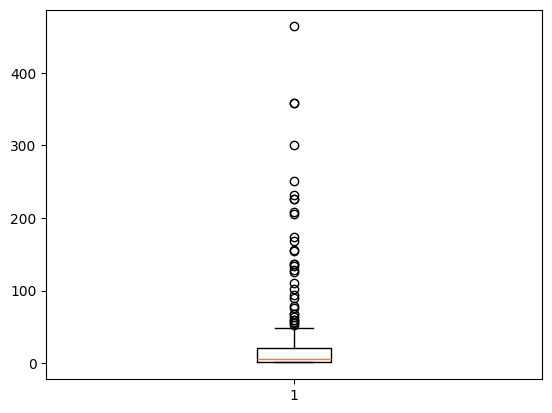

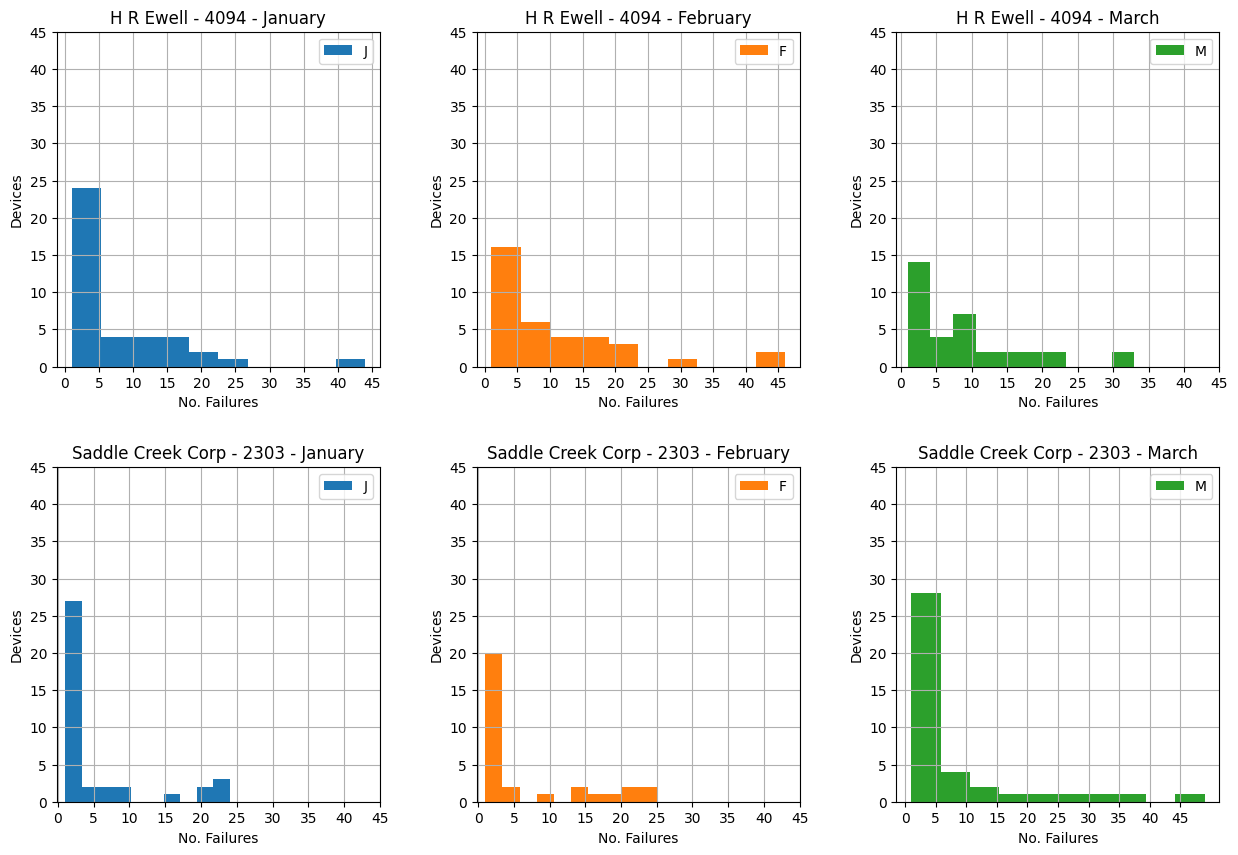

In [69]:
#DEVICE FAILURES GROUPED BY MONTH FOR EACH FLEET
grouper_month = alarms_df["Alarm time"].dt.month_name()
alarms_grouped_df = alarms_df.groupby([grouper_month, "Fleet"])["License plate number"].value_counts()
alarms_grouped_df = alarms_grouped_df.to_frame().reset_index().rename(columns={"count":"Failures", "Alarm time":"Month"})

#Rove monthly outliers
bp = plt.boxplot(alarms_grouped_df['Failures'])
bp_info = get_box_plot_data(['Failures'],bp)
display(bp_info)

#Remove monthly outliers
outlier_devices = alarms_grouped_df[alarms_grouped_df['Failures']>bp_info['upper_whisker'][0]]
alarms_grouped_df = alarms_grouped_df[~ alarms_grouped_df["License plate number"].isin(outlier_devices["License plate number"])]
devices_grouped_df = devices_df[~ devices_df["License plate No."].isin(outlier_devices["License plate number"])]
display(outlier_devices)
alarms_grouped_fleet_moth = alarms_grouped_df.pivot(index=["Fleet","License plate number"], columns="Month", values="Failures").reset_index()

fleets = alarms_grouped_df["Fleet"].unique()
months = sorted(alarms_grouped_df["Month"].unique(), key=lambda m: datetime.datetime.strptime(m, "%B"))

fig, axs = plt.subplots(len(fleets), len(months), figsize=(5*len(months), 5*len(fleets)))

i=0
for fleet_name in fleets :
    palette = itertools.cycle(sn.color_palette())
    j=0
    for month_name in months :
        hist_color = next(palette)
        data_fleet_month = alarms_grouped_df[(alarms_grouped_df["Fleet"]==fleet_name) & (alarms_grouped_df["Month"]==month_name)]
        data_fleet_month.hist(ax=axs[i,j], color=hist_color)
        plt.sca(axs[i,j])
        axs[i,j].set_ylabel("Devices")
        axs[i,j].set_xlabel("No. Failures")
        axs[i,j].set_title(fleet_name+' - '+month_name)
        axs[i,j].legend(month_name)
        plt.xticks(np.arange(0, 50, step=5))
        plt.yticks(np.arange(0, 50, step=5))

        j=j+1
    i=i+1

# display(alarms_grouped_df)

/tmp/ipykernel_187771/123333894.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alarms_group_by_speed["Speed"] = alarms_group_by_speed["Speed"].str.replace("mph","")
/tmp/ipykernel_187771/123333894.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alarms_group_by_speed["Speed"] = alarms_group_by_speed["Speed"].astype(int)


Text(0.5, 0, 'Speed (mph)')

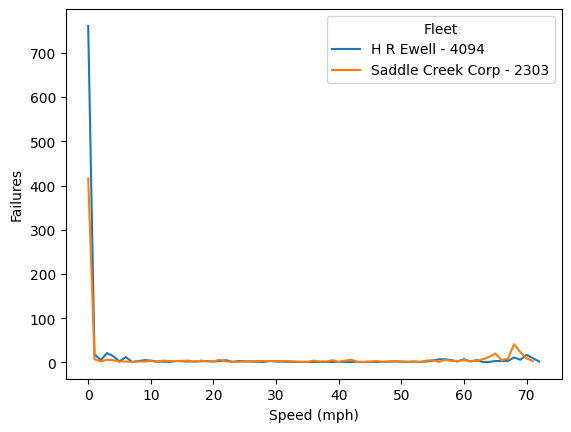

In [70]:

# Analise alarms/velocidade (histograma)
alarms_group_by_speed = alarms_df[~ alarms_df["License plate number"].isin(outlier_devices["License plate number"])]
alarms_group_by_speed["Speed"] = alarms_group_by_speed["Speed"].str.replace("mph","")
alarms_group_by_speed["Speed"] = alarms_group_by_speed["Speed"].astype(int)

alarms_group_by_speed = alarms_group_by_speed.groupby(["Fleet","Speed"])["Speed"].value_counts()
alarms_group_by_speed = alarms_group_by_speed.to_frame().reset_index().rename(columns={"count":"Failures"})

plot_ = sn.lineplot(alarms_group_by_speed, x="Speed",y="Failures",hue="Fleet")
new_ticks = [i.get_text() for i in plot_.get_xticklabels()]
plt.xlabel("Speed (mph)")


/tmp/ipykernel_187771/3501997553.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alarms_speed_df["Speed"] = alarms_speed_df["Speed"].str.replace("mph","")
/tmp/ipykernel_187771/3501997553.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alarms_speed_df["Speed"] = alarms_speed_df["Speed"].astype(int)


Text(0.5, 1.0, 'Video losses in movement')

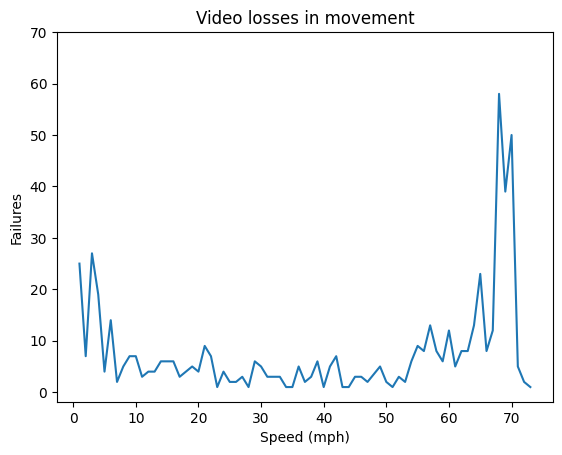

In [71]:
#Agrupar veiculos parados/em movimento
#Histograma
#Listar 10 veiculos para analise
alarms_speed_df = alarms_df[~ alarms_df["License plate number"].isin(outlier_devices["License plate number"])]
alarms_speed_df["Speed"] = alarms_speed_df["Speed"].str.replace("mph","")
alarms_speed_df["Speed"] = alarms_speed_df["Speed"].astype(int)
alarms_vehicles_moving = alarms_speed_df[alarms_speed_df["Speed"] > 0]


alarms_group_by_speed_moving = alarms_vehicles_moving.groupby(["Speed"])["Speed"].value_counts()
alarms_group_by_speed_moving = alarms_group_by_speed_moving.to_frame().reset_index().rename(columns={"count":"Failures"})

plot_ = sn.lineplot(alarms_group_by_speed_moving, x="Speed",y="Failures")
new_ticks = [i.get_text() for i in plot_.get_xticklabels()]
plt.xticks(np.arange(0, 80, step=10))
plt.yticks(np.arange(0, 80, step=10))
plt.xlabel("Speed (mph)")
plt.title("Video losses in movement")



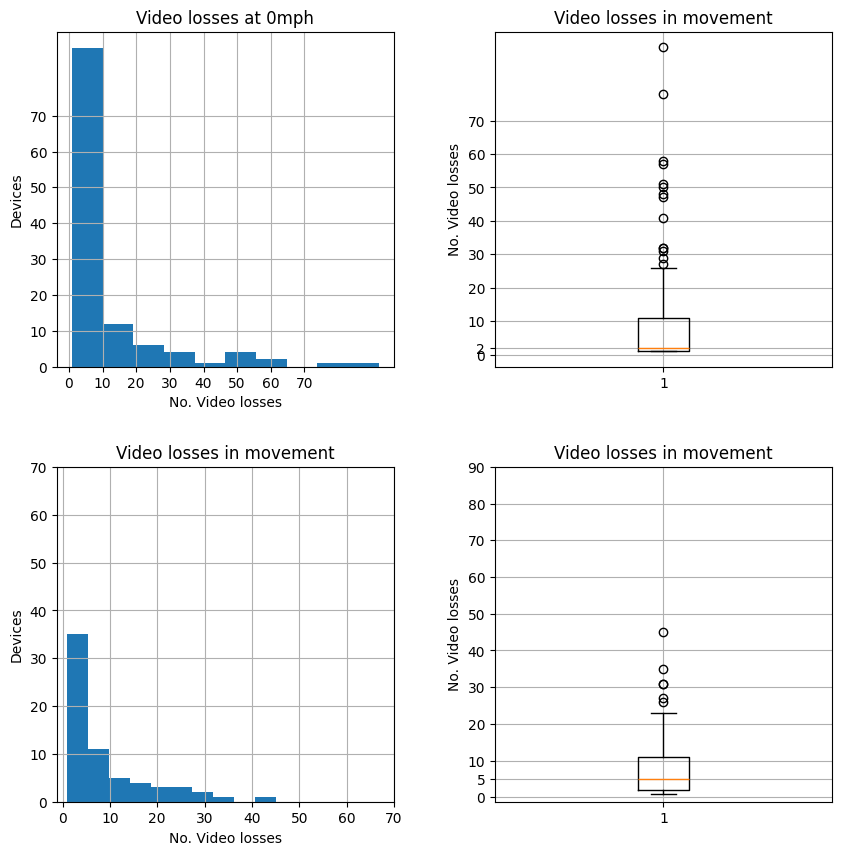

In [73]:
#### HISTOGRAM OF FAILURES WITH MOVING AND STOPPED VEHICLES ####
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

alarms_vehicles_stopped = alarms_speed_df[alarms_speed_df["Speed"] == 0]
alarms_vehicles_stopped = alarms_vehicles_stopped.groupby(["License plate number"])["License plate number"].value_counts()
alarms_vehicles_stopped = alarms_vehicles_stopped.to_frame().reset_index().rename(columns={"count":"Failures"})
alarms_vehicles_stopped.hist(ax=axs[0, 0])
plt.sca(axs[0,0])
plt.ylabel("Devices")
plt.xlabel("No. Video losses")
plt.title("Video losses at 0mph")
plt.xticks(np.arange(0, 100, step=10))
plt.yticks(np.arange(0, 100, step=10))

plt.sca(axs[0,1])
bp = plt.boxplot(alarms_vehicles_stopped['Failures'])
bp_info = get_box_plot_data(['Failures'],bp)
plt.ylabel("No. Video losses")
plt.title("Video losses in movement")
plt.yticks(np.append(np.arange(0, 100, step=10),bp_info['median']))
plt.grid()

alarms_vehicles_moving = alarms_speed_df[alarms_speed_df["Speed"] > 0]
alarms_vehicles_moving = alarms_vehicles_moving.groupby(["License plate number"])["License plate number"].value_counts()
alarms_vehicles_moving = alarms_vehicles_moving.to_frame().reset_index().rename(columns={"count":"Failures"})
alarms_vehicles_moving.hist(ax=axs[1,0])
plt.sca(axs[1,0])
plt.ylabel("Devices")
plt.xlabel("No. Video losses")
plt.title("Video losses in movement")
plt.xticks(np.arange(0, 100, step=10))
plt.yticks(np.arange(0, 100, step=10))

plt.sca(axs[1,1])
bp = plt.boxplot(alarms_vehicles_moving['Failures'])
bp_info = get_box_plot_data(['Failures'],bp)
plt.ylabel("No. Video losses")
plt.title("Video losses in movement")
plt.yticks(np.append(np.arange(0, 100, step=10),bp_info['median']))
plt.grid()

plt.show()       

In [68]:
#EXPORT CONSOLIDATED DATA
outlier_devices
consolidated_alarms = alarms_df[~ alarms_df["License plate number"].isin(outlier_devices["License plate number"])]
consolidated_devices = active_devices_df[~ active_devices_df["License plate No."].isin(outlier_devices["License plate number"])]
from_date = consolidated_alarms['Alarm time'].min().strftime("%Y-%m-%d")
to_date = consolidated_alarms['Alarm time'].max().strftime("%Y-%m-%d")
filename = "consolidated_alarms_"+from_date+"_to_"+to_date+".xlsx"
display(filename)
consolidated_alarms.to_excel(filename)
filename = "consolidated_devices_"+from_date+"_to_"+to_date+".xlsx"
consolidated_devices.to_excel(filename)

'consolidated_alarms_2024-01-01_to_2024-03-31.xlsx'